# Similarity of lamina circuits

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

import sys
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.utils import yymmdd_today
from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm, shortened_st

In [2]:
plt.rcdefaults()
plt.style.use('cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

save_figs = True
fig_path = f'/mnt/home/nchua/Dropbox/lamina_figures/{yymmdd_today()}/{yymmdd_today()}'

In [3]:
# Load dataframe of om->[connection counts]
tp = '210615'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

cxvecs = assemble_cxvectors(lamina_links)

In [4]:
# Filtering criteria
#unknowns = [c for c in df_lamina.columns if 'UNKNOWN' in c]   # discard columns involving connections to unidentified arbors
#df = df_lamina.drop(unknowns, axis=1).astype(float).dropna('columns')  # dropna effectively discards L4 associated connections
thresh = 1.0

cxvecs = cxvecs.loc[:, cxvecs.mean() > thresh].fillna(0)  # filter out connections with mean less than 1
cxvecs = cxvecs.rename_axis(index='om')

In [5]:
# Specifies colors for DRA and non-DRA ommatidia
def om_colors(om_list):
    #dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
    dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append('#434371')
        else:
            c_list.append('#C64191')
    return c_list

## Clustering by all connection types

## Clustering by connection counts

### All connections

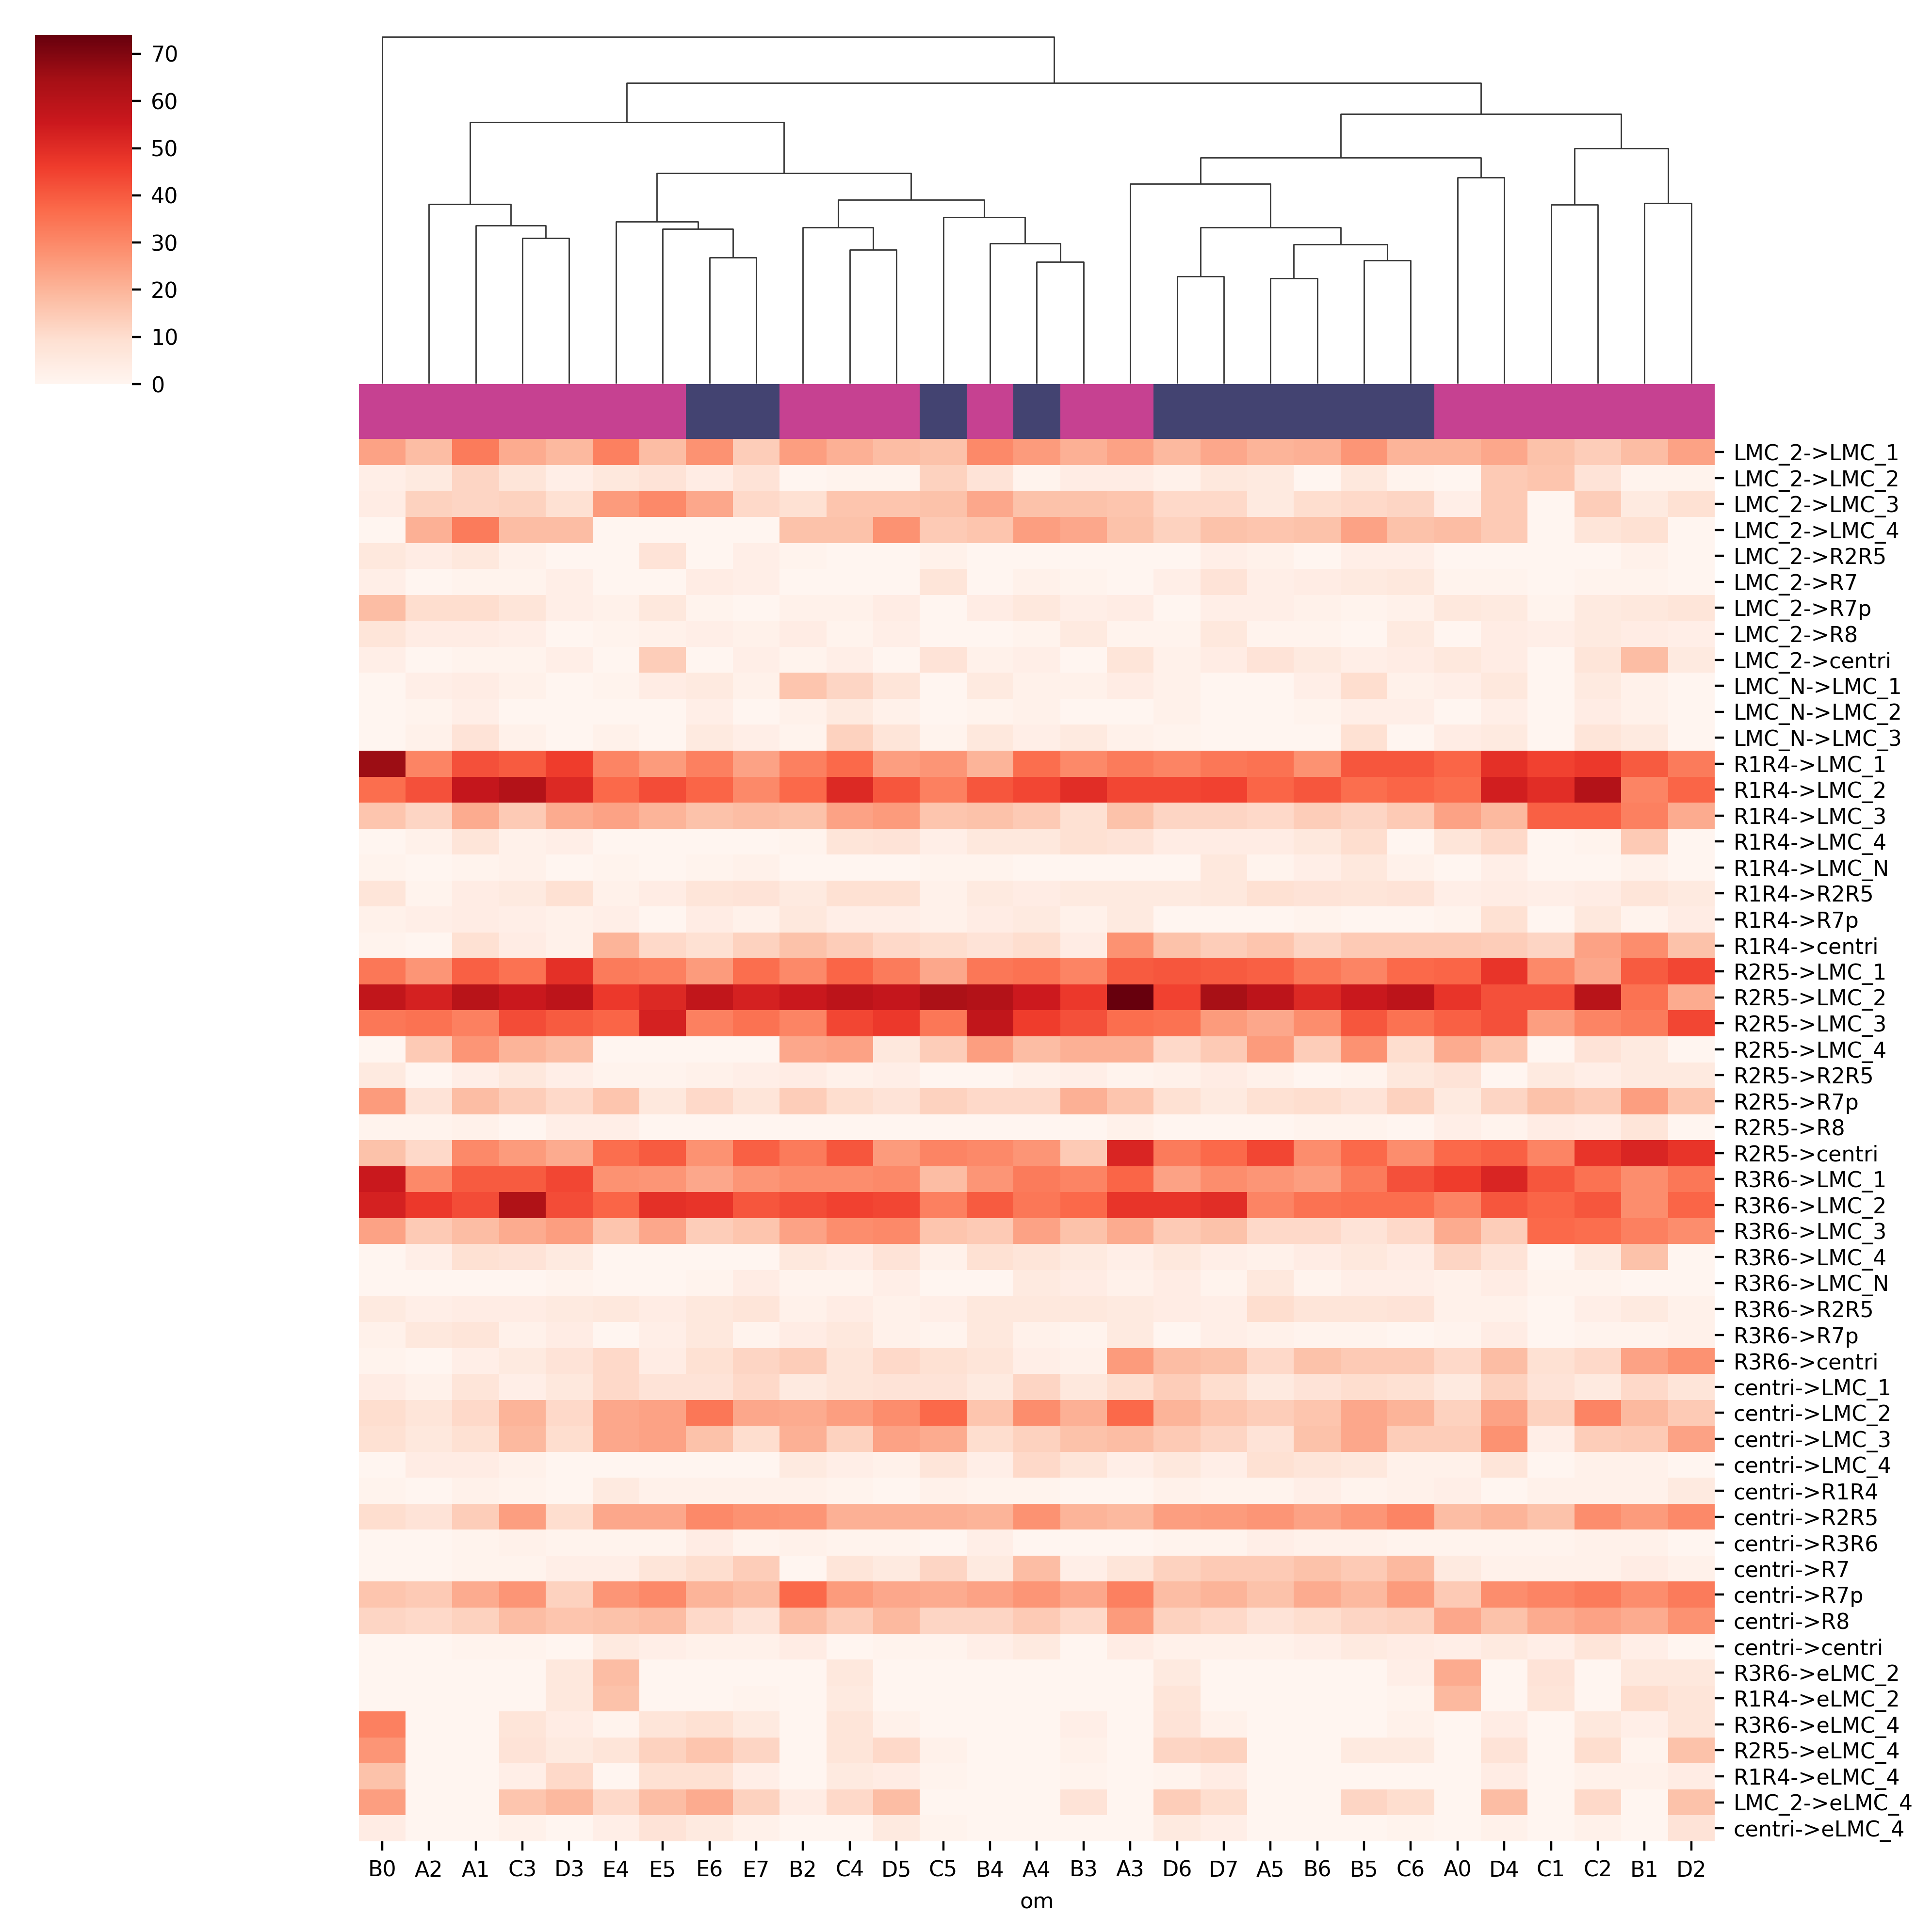

In [6]:
data = cxvecs.T
c_list = om_colors(data.columns)
clus = sns.clustermap(data, row_cluster=False, col_colors=c_list, yticklabels=data.index, metric='euclidean', 
                      method='complete', cmap='Reds')
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_allcx_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_allcx_thresh{thresh}.png')

### Home connections

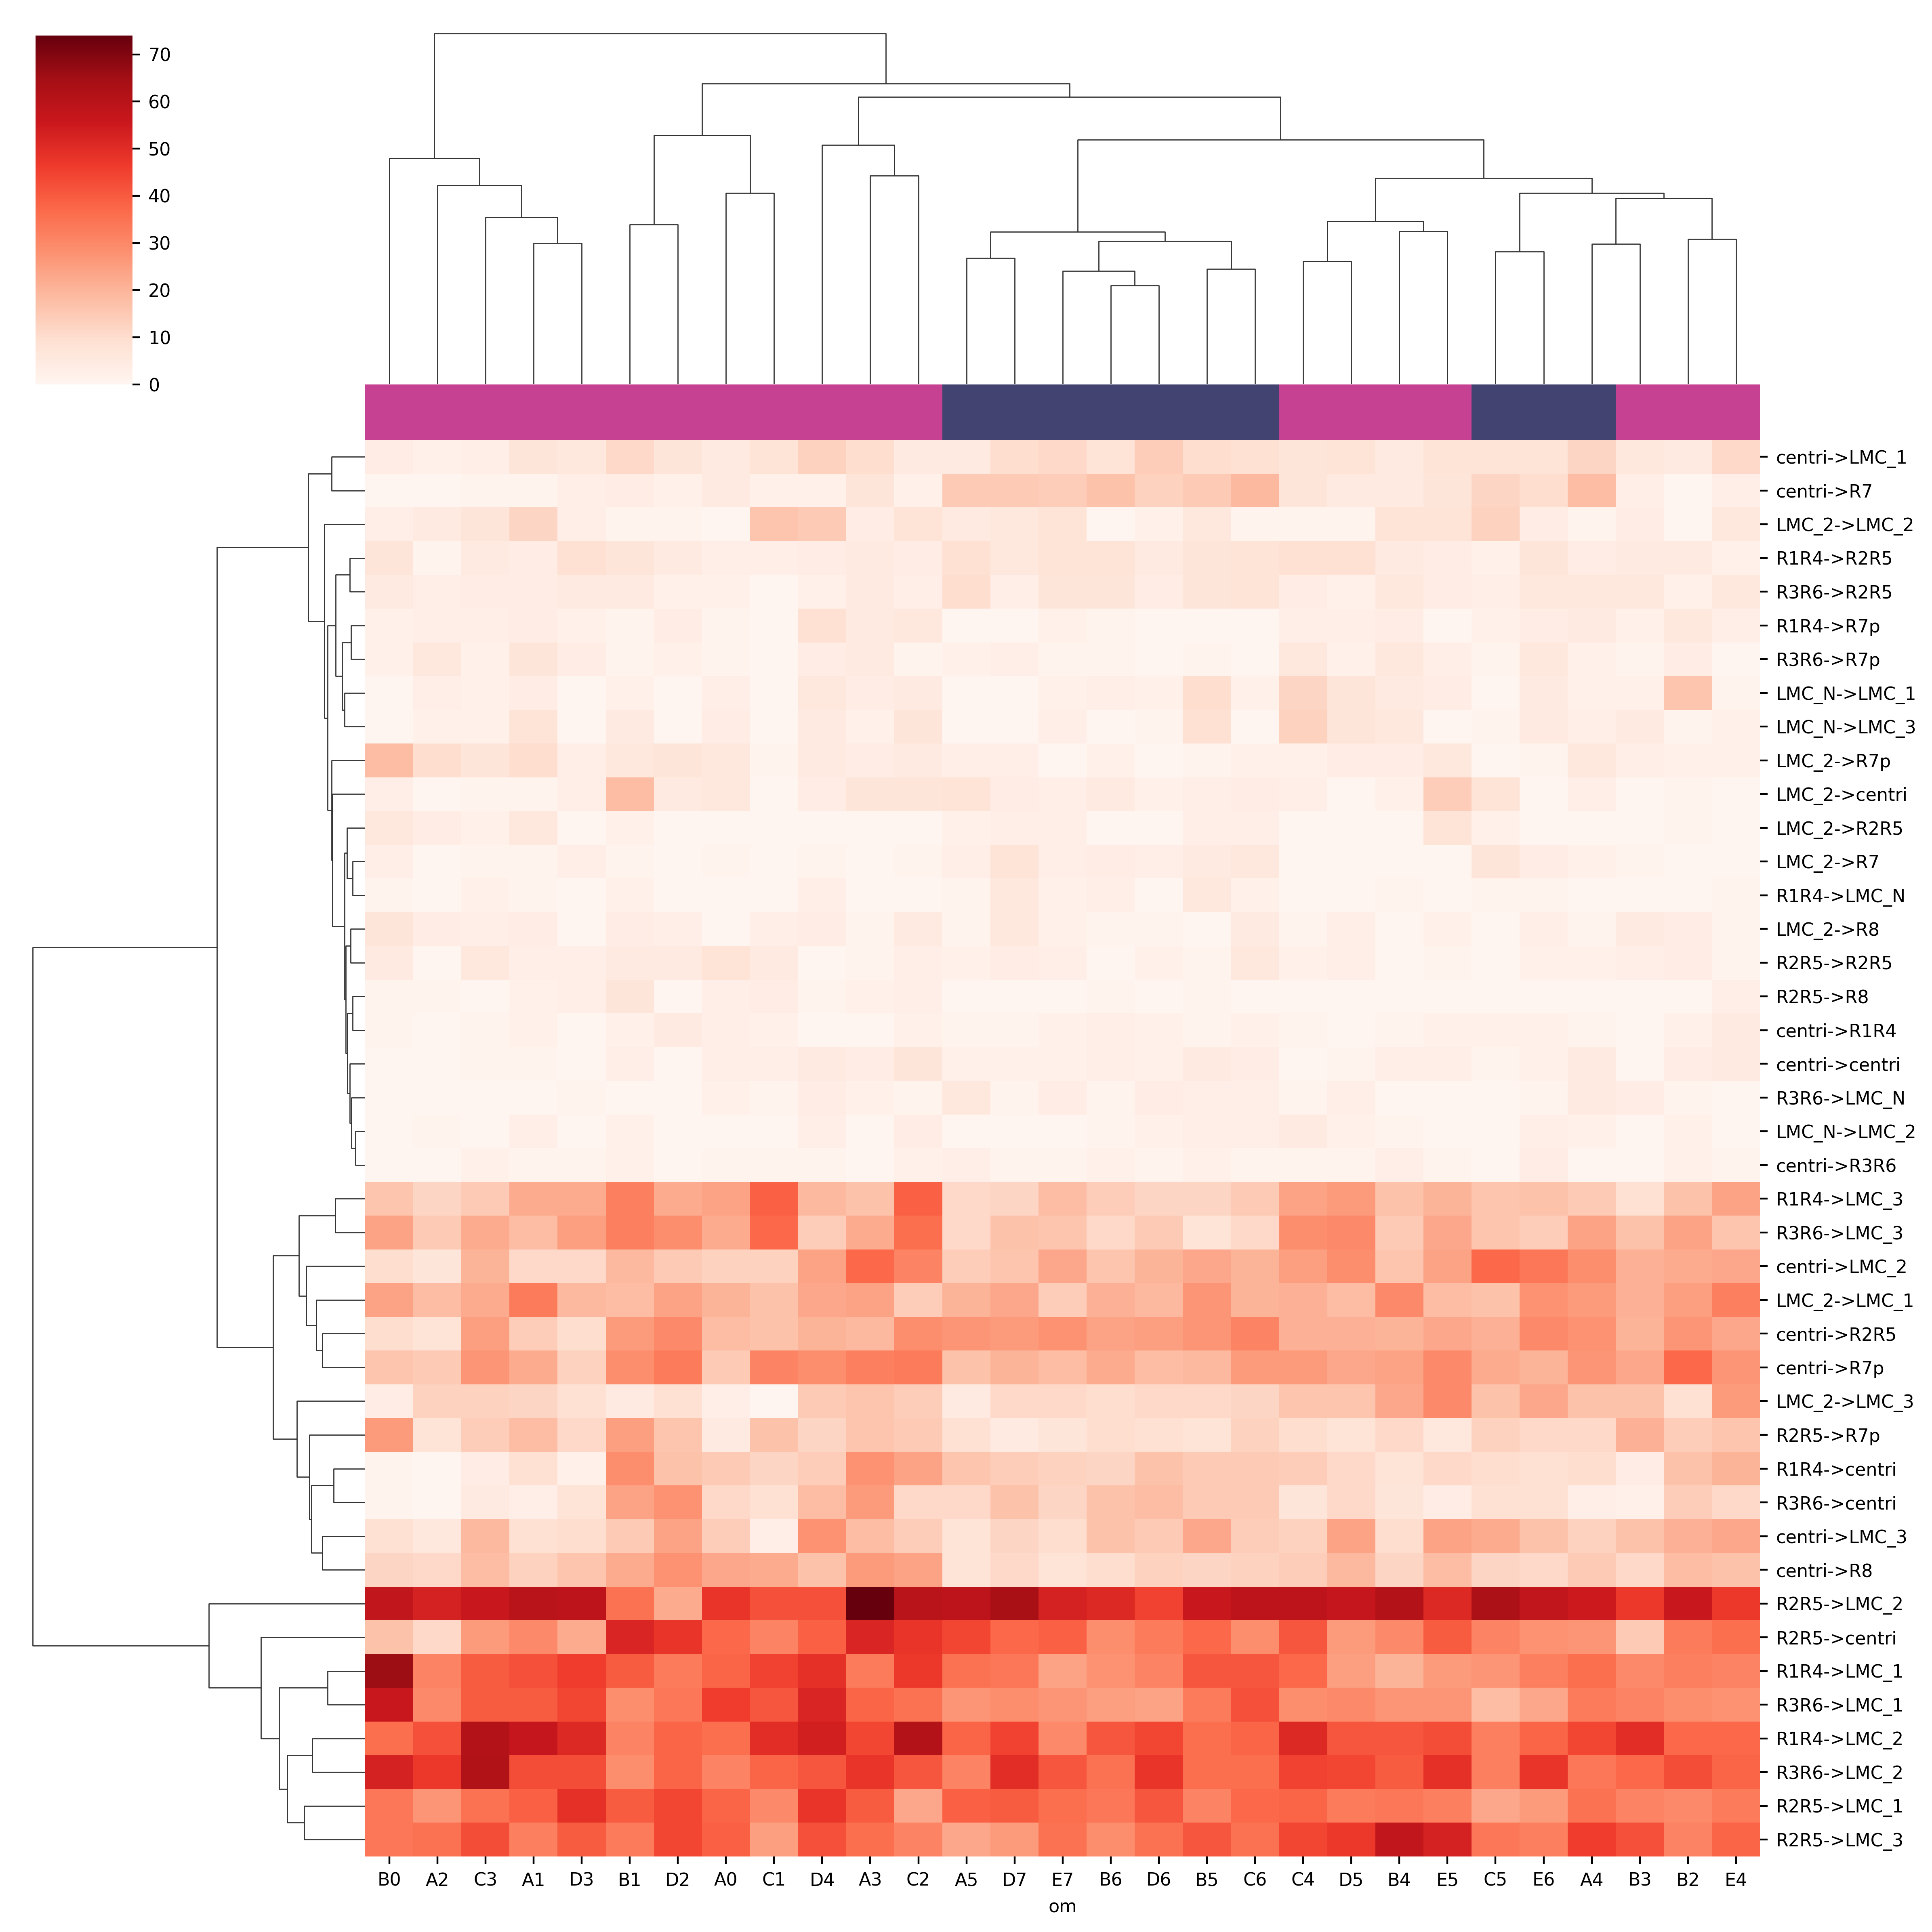

In [7]:
data = cxvecs.loc[:, [i for i in cxvecs.columns if ('LMC_4' not in i) and ('eLMC_2' not in i)]].T
c_list = om_colors(data.columns)
clus = sns.clustermap(data, row_cluster=True, col_colors=c_list, figsize=[12,12], cmap='Reds',
                      yticklabels=data.index, metric='euclidean', method='complete')
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_homecx_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_homecx_thresh{thresh}.png')

## Inputs to R7, R8, R7'

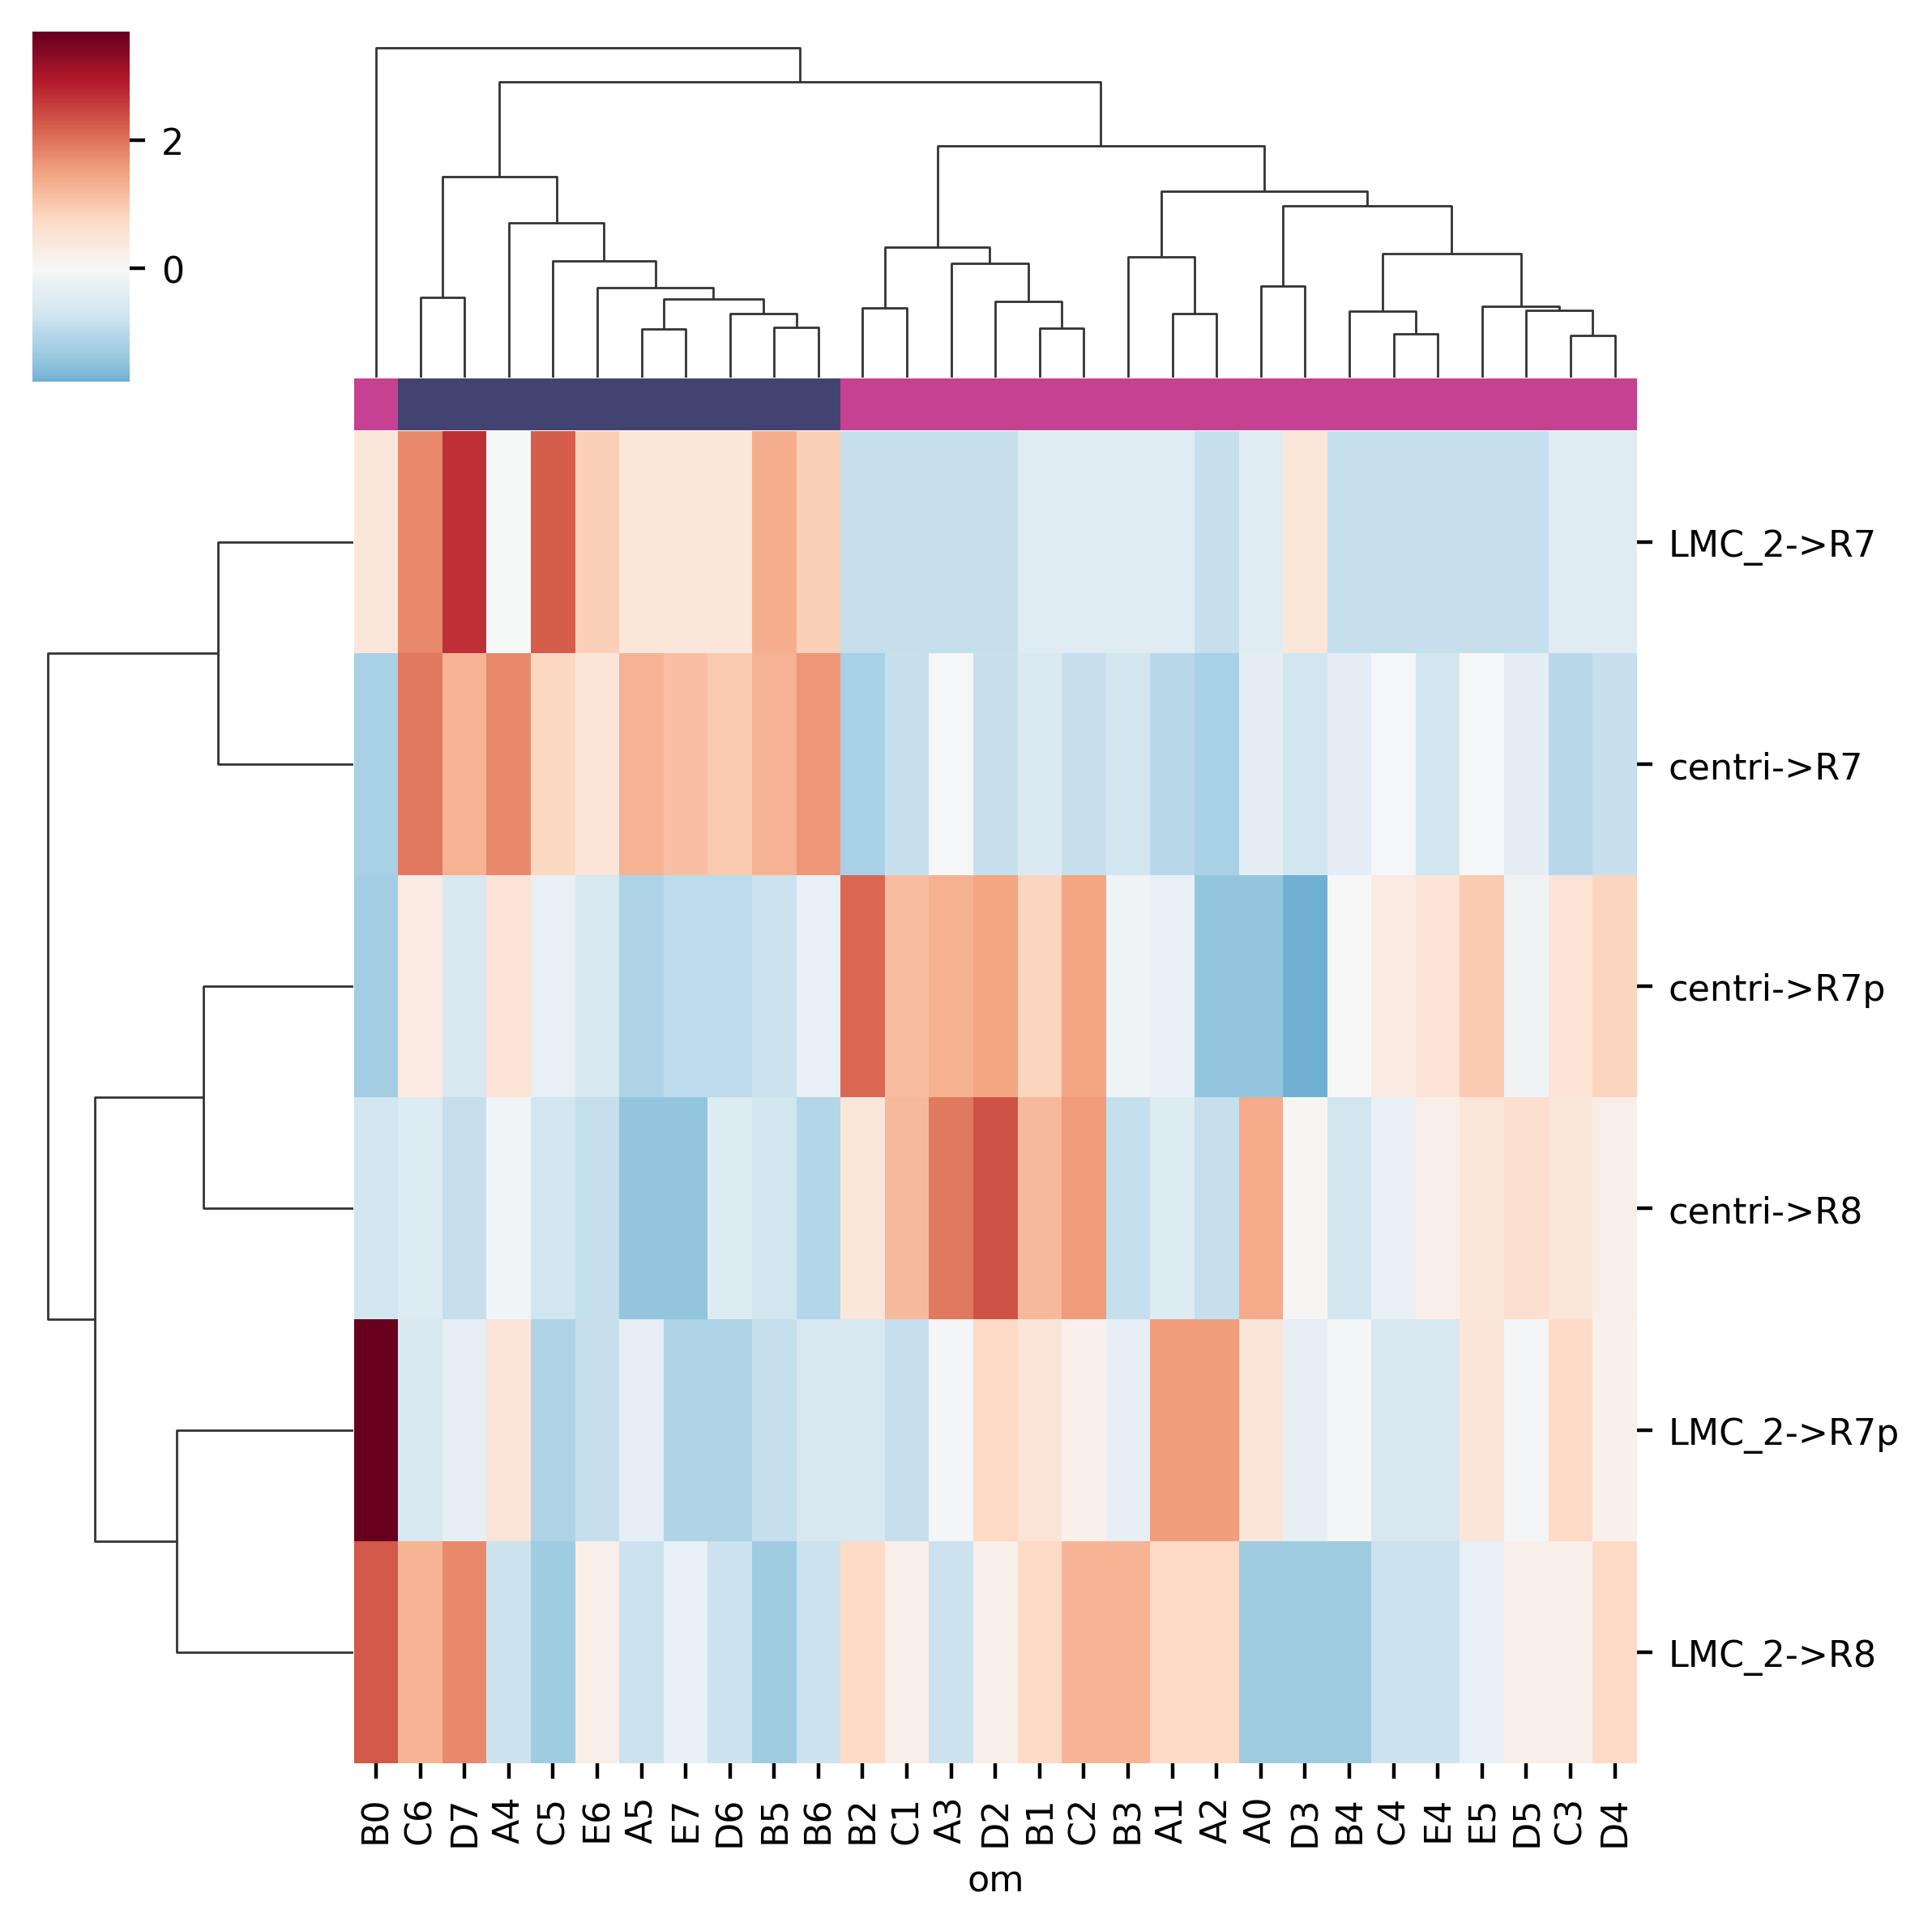

In [8]:
data = cxvecs.filter(regex='(centri|LMC_2)->R(7|8)', axis=1)

z = data.apply(zscore)
z = z.T


clus = sns.clustermap(z, row_cluster=True, col_colors=c_list, figsize=[6,6], cmap='RdBu_r', center=0,
                      yticklabels=z.index, metric='euclidean', method='complete')

plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')

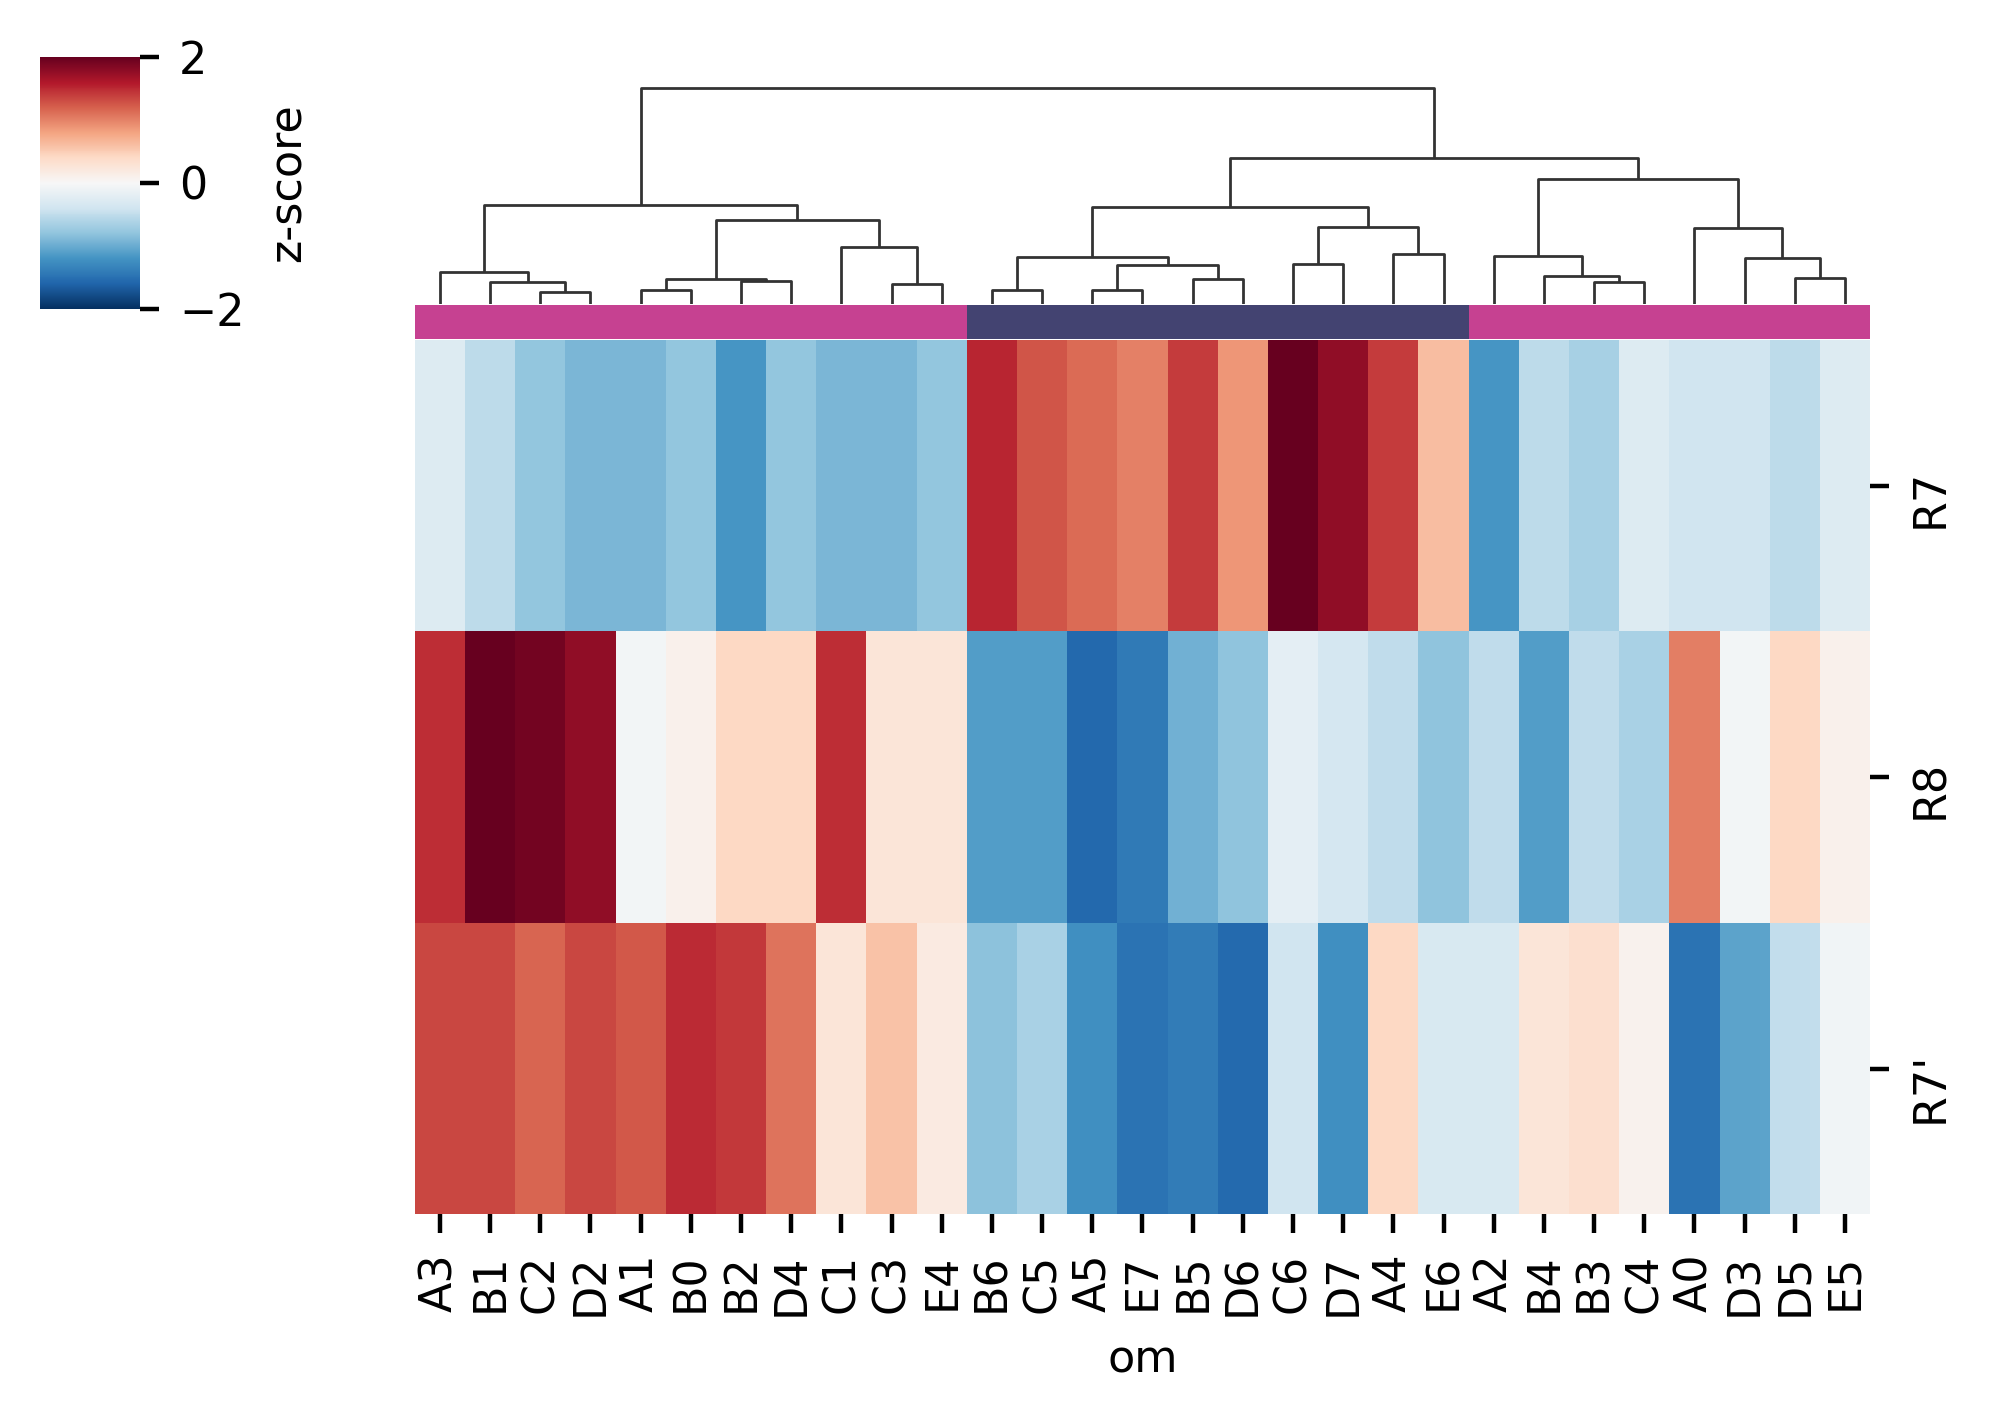

In [10]:
total_inputs = pd.DataFrame([cxvecs.filter(regex='->R7$').sum(axis=1), 
                            cxvecs.filter(regex='->R8$').sum(axis=1), 
                            cxvecs.filter(regex='->R7p$').sum(axis=1)], index=['R7', 'R8', "R7'"]). T

#display(total_inputs)

z = total_inputs.apply(zscore)
z = z.T


clus = sns.clustermap(z, row_cluster=False, col_colors=c_list, figsize=[5,3.5], 
                      cbar_kws={'ticks': [2, 0, -2], 'label': 'z-score'}, cmap='RdBu_r', center=0, vmin=-2, vmax=2,
                      xticklabels=z.columns, yticklabels=z.index, metric='euclidean', method='complete')
plt.show()

if save_figs:
    clus.savefig(fig_path + 'RETVAR-lvf-inputs-clust.svg')
    clus.savefig(fig_path + 'RETVAR-lvf-inputs-clust.png')

In [ ]:
z

## Clustering by z-score of connection counts

In [ ]:
z_scores = pd.DataFrame(index=cxvecs.index, columns=cxvecs.columns)

for cx, vec in cxvecs.T.iterrows():
    z_scores.loc[:, cx] = (vec - vec.mean())/vec.std(ddof=0)

### All connections

In [ ]:
data = z_scores.T
c_list = om_colors(data.columns)
clus = sns.clustermap(data, col_colors=c_list, yticklabels=data.index, metric='cosine', method='average',
                      cmap='RdBu_r', label='z-score')
plt.show()

if save_figs:
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_z-score_allcx.svg')
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_z-score_allcx.png')

### Home connections

In [ ]:
data = z_scores.loc[:, [i for i in cxvecs.columns if ('LMC_4' not in i) and ('eLMC_2' not in i)]].T
c_list = om_colors(data.columns)
clus = sns.clustermap(data, col_colors=c_list, yticklabels=data.index, metric='cosine', method='average',
                      cmap='RdBu_r', center=0)
plt.show()

if save_figs:
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_z-score_homecx.svg')
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_z-score_homecx.png')

## Clustering by correlation of connection counts

In [ ]:
data = cxvecs.T.corr()
c_list = om_colors(data.columns)

clus = sns.clustermap(data, metric='euclidean', method='average',  # average = centroid linkage
                      col_colors=c_list, cmap='YlGnBu', vmin=0.75, vmax=1)

plt.show()

if save_figs:
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_corr_allcx.svg')
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_corr_allcx.png')

In [ ]:
data = cxvecs.loc[:, [i for i in cxvecs.columns if ('LMC_4' not in i) and ('eLMC_2' not in i)]].T.corr()
#display(cxvecs.loc[:, [i for i in cxvecs.columns if ('LMC_4' not in i) and ('eLMC_2' not in i)]])
c_list = om_colors(data.columns)


sns.clustermap(data, metric='euclidean', method='average',  # average = centroid linkage
               col_colors=c_list, cmap='RdBu')

if save_figs:
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_corr_homecx.svg')
    clus.savefig('/mnt/home/nchua/Dropbox/lamina_figures/om_clus_corr_homecx.png')